In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os
from PIL import Image
import time
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive")

Mounted at /content/drive


#Lectura de imagenes procesadas

In [ ]:
df= pd.read_pickle('/content/drive/Shareddrives/2024_RedesNeuronales/Proyecto Final/Primer avance/ImagenesProcesadas/falciparum_parte1.pkl')

In [ ]:
df.columns

Index(['id_recorte', 'x_centro', 'y_centro', 'x_start', 'x_end', 'y_start',
       'y_end', 'recorte', 'ID_nota', 'es_parasito', 'paciente', 'imagen',
       'especie'],
      dtype='object')

In [ ]:
df

,id_recorte,x_centro,y_centro,x_start,x_end,y_start,y_end,recorte,ID_nota,es_parasito,paciente,imagen,especie
0,1,1291,2408,1269,1313,2386,2430,"[[[235, 224, 241], [236, 228, 243], [234, 226,...",NaN,0,TF100_CS39,20170829_210416,1
1,2,2613,1441,2591,2635,1419,1463,"[[[178, 147, 206], [175, 144, 203], [174, 140,...",NaN,0,TF100_CS39,20170829_210416,1
2,3,2389,1099,2367,2411,1077,1121,"[[[209, 177, 214], [208, 176, 213], [207, 175,...",8-4,1,TF100_CS39,20170829_210416,1
3,4,2559,601,2537,2581,579,623,"[[[204, 164, 217], [205, 167, 218], [208, 170,...",8-1,1,TF100_CS39,20170829_210416,1
4,5,2328,1196,2306,2350,1174,1218,"[[[203, 171, 210], [199, 167, 206], [202, 167,...",8-5,1,TF100_CS39,20170829_210416,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194617,23,2426,1630,2404,2448,1608,1652,"[[[113, 20, 197], [142, 50, 213], [173, 81, 22...",NaN,0,TF101_233,20170830_104641,1
1194618,24,1224,682,1202,1246,660,704,"[[[92, 3, 171], [91, 2, 170], [92, 1, 167], [9...",NaN,0,TF101_233,20170830_104641,1
1194619,25,1955,1058,1933,1977,1036,1080,"[[[223, 194, 225], [224, 195, 226], [224, 195,...",NaN,0,TF101_233,20170830_104641,1
1194620,26,2350,1589,2328,2372,1567,1611,"[[[227, 203, 229], [225, 201, 227], [227, 203,...",NaN,0,TF101_233,20170830_104641,1


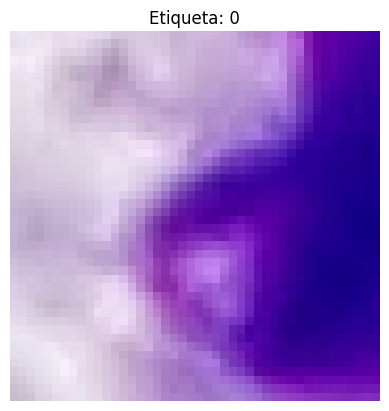

In [ ]:
# Seleccionar una fila del DataFrame para visualizar
fila = 0  # imágenes
img = df['recorte'].iloc[fila]  # Obtener el array de la columna 'recorte'

# Mostrar la imagen
plt.imshow(img.astype('uint8'))
plt.title(f"Etiqueta: {df['es_parasito'].iloc[fila]}")  # Título con la etiqueta 'es_parasito'
plt.axis('off')  # Quitar los ejes
plt.show()


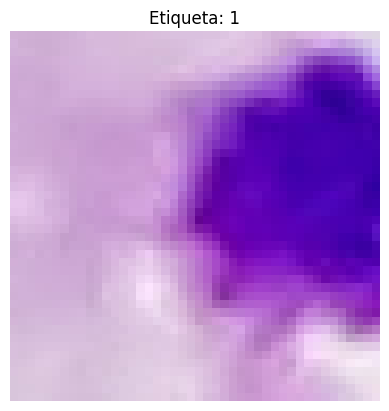

In [ ]:
# Seleccionar una fila del DataFrame para visualizar
fila = 2
img = df['recorte'].iloc[fila]  # Obtener el array de la columna 'recorte'

# Mostrar la imagen
plt.imshow(img.astype('uint8'))
plt.title(f"Etiqueta: {df['es_parasito'].iloc[fila]}")  # Título con la etiqueta 'es_parasito'
plt.axis('off')  # Quitar los ejes
plt.show()


# Preprocesamiento para entrada de MLP

In [ ]:
# Tomar una muestra aleatoria del DataFrame
# Porque colab tiene limite de ram :'|)

# Filtrar las filas de cada clase
parasitos = df[df['es_parasito'] == 1]  # Filas donde hay parásitos
no_parasitos = df[df['es_parasito'] == 0]  # Filas donde no hay parásitos

# Tomar una muestra de 25,000 de cada clase
muestra_parasitos = parasitos.sample(n=25000, random_state=42)
muestra_no_parasitos = no_parasitos.sample(n=25000, random_state=42)

# Combinar ambas muestras
df_balanceado = pd.concat([muestra_parasitos, muestra_no_parasitos])

# Mezclar las filas del nuevo dataset balanceado
df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)  # Mezcla completa



In [ ]:
# Función para convertir a escala de grises
def convertir_a_grises(imagen_rgb):
    return cv2.cvtColor(imagen_rgb, cv2.COLOR_RGB2GRAY)

# Aplicar la conversión a la columna 'recorte'
df_balanceado['recorte_gris'] = df_balanceado['recorte'].apply(convertir_a_grises)

# Aplanar las imágenes
df_balanceado['recorte_aplanado'] = df_balanceado['recorte'].apply(lambda x: x.flatten())



In [ ]:
# Normalizar las imágenes aplanadas
df_balanceado['recorte_normalizado'] = df_balanceado['recorte_aplanado'].apply(lambda x: x / 255.0)

# Crear X (entradas) y y (etiquetas)
X = np.stack(df_balanceado['recorte_normalizado'].values)  # Convertir la lista de arrays en un tensor NumPy
y = df_balanceado['es_parasito'].values  # Etiquetas (0 o 1)

## División de entrenamiento

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#Modelo

In [ ]:
44*44*3

5808

In [ ]:
X_train.shape[1]

5808

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definir el modelo MLP
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),  # Primera capa oculta
    Dropout(0.3),  # Regularización para evitar sobreajuste
    Dense(64, activation='relu'),  # Segunda capa oculta
    Dropout(0.3),  # Más regularización
    Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Entrenar el modelo
history = model.fit(X_train, y_train,
                    validation_split=0.2,  # Usar un 20% del conjunto de entrenamiento para validación
                    epochs=40,  # Ajustar
                    batch_size=32,  # Tamaño del batch
                    verbose=1)  # Muestra detalles del entrenamiento

Epoch 1/40
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7628 - loss: 0.5227 - val_accuracy: 0.8827 - val_loss: 0.3123
Epoch 2/40
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8531 - loss: 0.3568 - val_accuracy: 0.9089 - val_loss: 0.2641
Epoch 3/40
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8672 - loss: 0.3346 - val_accuracy: 0.9119 - val_loss: 0.2735
Epoch 4/40
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8752 - loss: 0.3221 - val_accuracy: 0.9187 - val_loss: 0.2590
Epoch 5/40
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8792 - loss: 0.3194 - val_accuracy: 0.9041 - val_loss: 0.2594
Epoch 6/40
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8881 - loss: 0.2976 - val_accuracy: 0.9360 - val_loss: 0.2183
Epoch 7/40
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9106 - loss: 0.2620 - val_accuracy: 0.9341 - val_loss: 0.2230
Epoch 8/40
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9019 - loss: 0.2751 - val_accuracy: 0.

In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Precisión en datos de prueba: {accuracy * 100:.2f}%")

Precisión en datos de prueba: 94.63%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Generar predicciones
y_pred = (model.predict(X_test) > 0.5).astype('int32')  # Convertir probabilidades a 0/1

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      7432
           1       0.91      1.00      0.95      7568

    accuracy                           0.95     15000
   macro avg       0.95      0.95      0.95     15000
weighted avg       0.95      0.95      0.95     15000


Matriz de confusión:
[[6640  792]
 [  14 7554]]


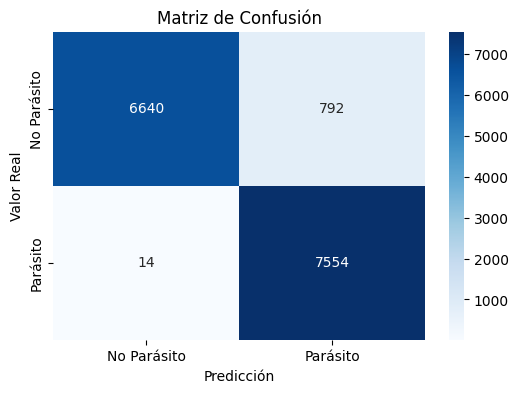

In [ ]:
import seaborn as sns

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear un heatmap para la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Parásito", "Parásito"], yticklabels=["No Parásito", "Parásito"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

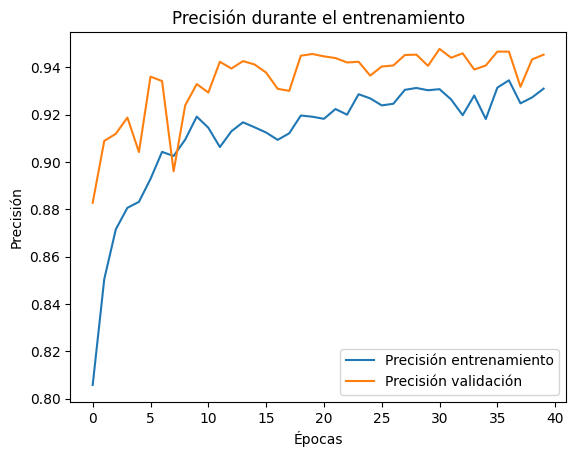

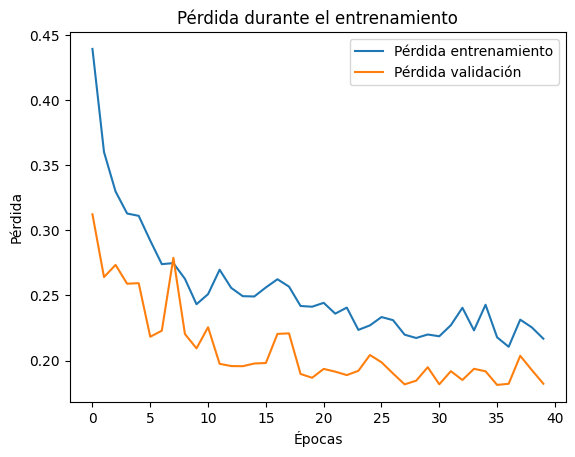

In [ ]:
import matplotlib.pyplot as plt

# Graficar precisión
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar pérdida
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


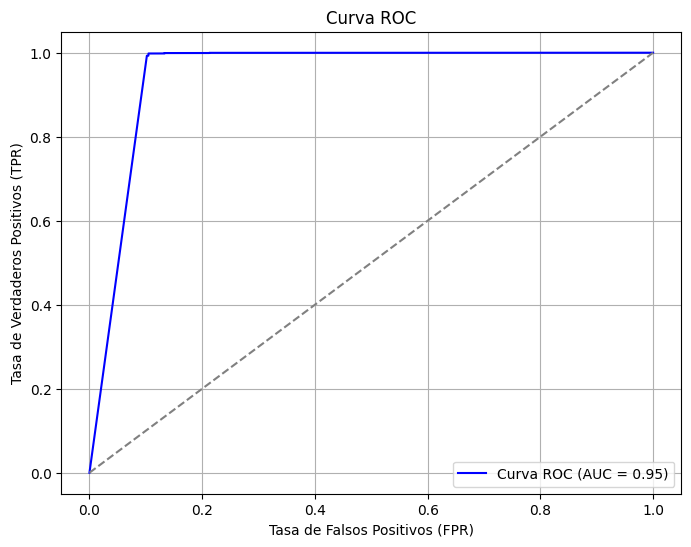

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas (en lugar de las clases predichas)
y_pred_prob = model.predict(X_test).ravel()  # Probabilidades predichas para la clase positiva

# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
